In [98]:
from pyspark.sql.session import SparkSession
from pyspark import SparkContext
import pyspark
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from matplotlib import style
style.use("ggplot")
from pyspark.sql.functions import year, month, dayofmonth
init_notebook_mode(connected=True)
from matplotlib import pyplot as plt

import os
#os.environ["SPARK_HOME"] = "/usr/local/spark"
os.environ["PYSPARK_PYTHON"] ="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] ="python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] ="notebook"

In [78]:
def dfToList(dfnm,colnm):
    return dfnm.rdd.map(lambda row : row[colnm]).collect()

In [79]:
def rdd_int(dfnm,colnm):
    return dfnm.rdd.map(lambda row : row[colnm]).reduce(lambda row : map(int, row))


In [3]:
sc = SparkContext(master = 'local[2]')
spark = SparkSession(sc)


In [6]:
donationsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/donations.parquet")

In [7]:
donorsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/donors.parquet")

In [8]:
projectsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/projects.parquet")

In [9]:
resourcesDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/resources.parquet")

In [10]:
schoolsDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/schools.parquet")

In [11]:
TeachersDF = spark.read.parquet("hdfs://localhost:9000/inputs/DonorChoose/teachers.parquet")

In [12]:
donor_donation = donationsDF.join(donorsDF,['DonorID'])

In [15]:
project_desc=donationsDF.join(projectsDF,['projectID']).join(donorsDF,['DonorID'])

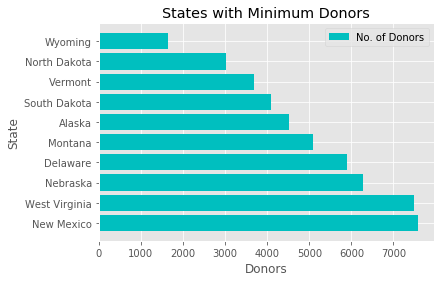

In [160]:
tempDF=donorsDF.select('DonorState').groupby('DonorState').count().orderBy('count',ascending=True).limit(10)
donor, state = tempDF.rdd.map(lambda row : row['DonorState']).collect(), tempDF.rdd.map(lambda row : row['count']).collect()
plt.grid(True)
plt.barh(donor[::-1],state[::-1],label="No. of Donors",color='c')#reverse list for expected output 
plt.xlabel("Donors")
plt.ylabel("State")
plt.title("States with Minimum Donors")
plt.legend()

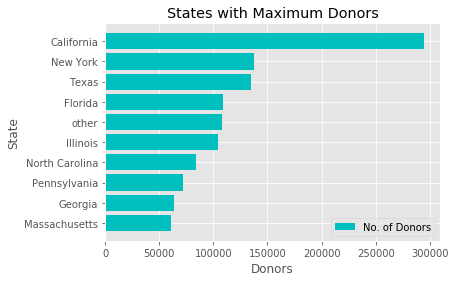

In [161]:
tempDF=donorsDF.select('DonorState').groupby('DonorState').count().orderBy('count',ascending=False).limit(10)
donor = tempDF.rdd.map(lambda row : row.DonorState).collect()
state = tempDF.rdd.map(lambda row : row['count']).collect()
plt.grid(True)
plt.barh(donor[::-1],state[::-1],label="No. of Donors",color='c')#reverse list for expected output 
plt.xlabel("Donors")
plt.ylabel("State")
plt.title("States with Maximum Donors")
plt.legend()

In [19]:
tmptech=donorsDF.groupby(['DonorState','DonorIsTeacher']).agg({'DonorIsTeacher':'count'}).orderBy(['DonorState','count(DonorIsTeacher)'],ascending=True)

In [20]:
yes_df=tmptech[tmptech['DonorIsTeacher']=='Yes']
yes_x,yes_y=dfToList(yes_df,'DonorState'),dfToList(yes_df,'count(DonorIsTeacher)')

no_df = tmptech[tmptech['DonorIsTeacher']=='No']
no_x,no_y =dfToList(no_df,'DonorState'),dfToList(no_df,'count(DonorIsTeacher)')


In [21]:
trace1 = go.Bar(
    x=no_x,
    y=no_y,
    name='Non Teacher Donors',
    marker=dict(color='#f259d6'),
    opacity=0.8
)
trace2 = go.Bar(
    x=yes_x,
    y=yes_y,
    name='Teacher Donors',
    marker=dict(color='#f7bb31'),
    opacity=0.8
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    legend=dict(dict(x=-.1, y=1.2)),
    margin=dict(b=120),
    title = 'States and the distribution of Teacher and Non Teacher Donors',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [33]:
no_donation=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'}).orderBy('count(ProjectID)',ascending=False).limit(10)

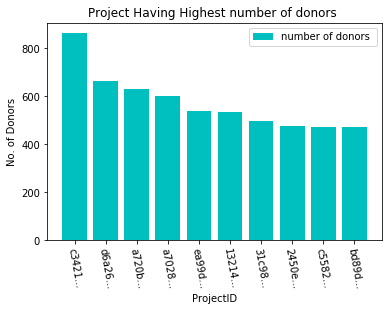

In [34]:
project = dfToList(no_donation,'ProjectID')
project=[project[i][:5]+'...' for i in range(len(project))]
donation =dfToList(no_donation,'count(ProjectID)')
plt.ylabel("No. of Donors")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)

plt.bar(project,donation,label="number of donors ",color='c')
plt.title("Project Having Highest number of donors ")
plt.legend()


In [36]:
tmpfund=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'}).orderBy('sum(DonationAmount)',ascending=False).limit(10)

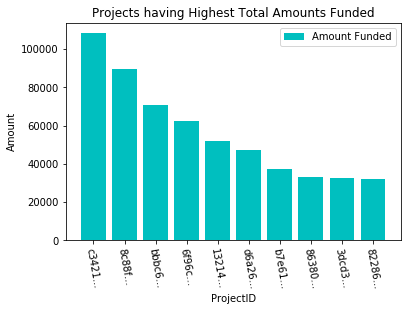

In [37]:
project = dfToList(tmpfund,'ProjectID')
project=[project[i][:5]+'...' for i in range(len(project))]
donation = dfToList(tmpfund,'sum(DonationAmount)')
plt.ylabel("Amount")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)
plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("Projects having Highest Total Amounts Funded")
plt.legend()

In [41]:
tmp_fund=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).limit(10)

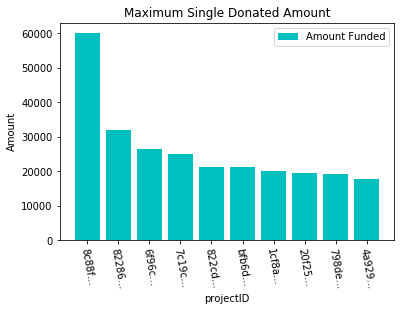

In [43]:
project =dfToList(tmp_fund,'ProjectID')
project=[project[i][:5]+'...' for i in range(len(project))]
donation = dfToList(tmp_fund,'max(DonationAmount)')
plt.ylabel("Amount")
plt.xlabel("projectID")
plt.xticks(rotation=-80)

plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("Maximum Single Donated Amount")
plt.legend()


In [44]:
tempDF=project_desc.groupby('ProjectID').agg({'ProjectID':'count','DonationAmount':'sum'})
tmp_fund=tempDF.withColumn('AvgAm',tempDF['sum(DonationAmount)'] / tempDF['count(ProjectID)']).select('*').filter(tempDF['count(ProjectID)'] > 10).orderBy('AvgAm',ascending=False).limit(10)

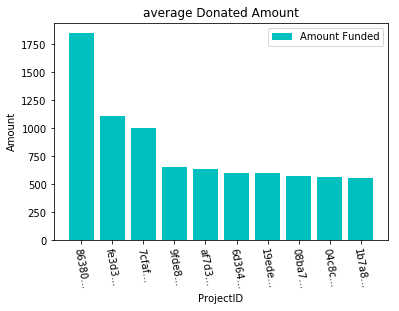

In [45]:
project = dfToList(tmp_fund,'ProjectID')
project=[project[i][:5]+'...' for i in range(len(project))]
donation = dfToList(tmp_fund,'AvgAm')
plt.ylabel("Amount")
plt.xlabel("ProjectID")
plt.xticks(rotation=-80)
plt.bar(project,donation,label="Amount Funded",color='c')
plt.title("average Donated Amount")
plt.legend()


In [46]:
#Who are the Top Donors
	#Donors who have made highest number of donations 
tmp_don=donor_donation.groupby('DonorID').agg({'DonorID':'count','DonationAmount':'sum'}).orderBy('count(DonorID)',ascending=False).limit(10)

Text(0.5, 1.0, 'number of donations')

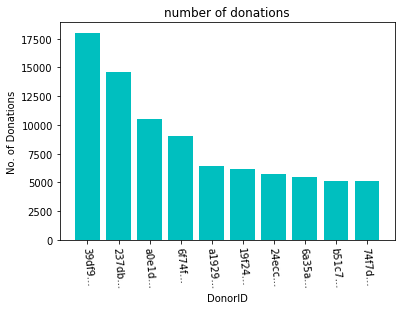

In [47]:
donor = dfToList(tmp_don,'DonorID')
donor= [donor[i][:5]+'...' for i in range(len(donor))]
donor_sum = dfToList(tmp_don,'count(DonorID)')
plt.ylabel("No. of Donations")
plt.xlabel("DonorID")
plt.xticks(rotation=-85)

plt.bar(donor,donor_sum,color='c')
plt.title("number of donations")


In [49]:
tmp_don=donor_donation.groupby('DonorID').agg({'DonorID':'count','DonationAmount':'sum'}).orderBy('sum(DonationAmount)',ascending=False).limit(10)

Text(0.5, 1.0, 'Donors who have funded Highest Total Amounts')

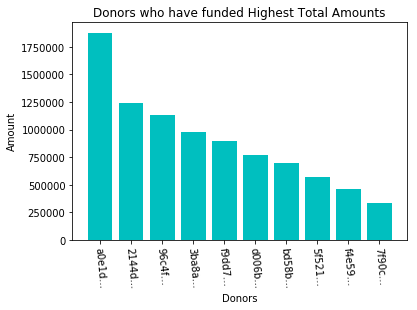

In [50]:
donor = dfToList(tmp_don,'DonorID')
donor=[donor[i][:5]+'...' for i in range(len(donor))]
donor_sum = dfToList(tmp_don,'sum(DonationAmount)')
plt.ylabel("Amount")
plt.xlabel("Donors")
plt.xticks(rotation=-85)

plt.bar(donor,donor_sum,color='c')
plt.title("Donors who have funded Highest Total Amounts")


In [51]:
donationPD=donationsDF.groupby('DonationIncludedOptionalDonation').agg({'DonationIncludedOptionalDonation':'count','DonationAmount':'mean'})

In [80]:
yes_df=donationPD[donationPD['DonationIncludedOptionalDonation']=='Yes']
yes_mean=rdd_int(yes_df,'avg(DonationAmount)')
yes_df_1= rdd_int(yes_df,'count(DonationIncludedOptionalDonation)')

no_df = donationPD[donationPD['DonationIncludedOptionalDonation']=='No']
no_mean=rdd_int(no_df,'avg(DonationAmount)')
no_df_1 =rdd_int(no_df,'count(DonationIncludedOptionalDonation)') 


In [90]:

#4001709

4001709

Text(0.5, 1.0, 'Total Optional Donation')

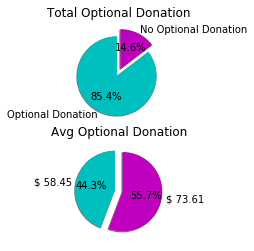

In [81]:
yes_no = [int(yes_df_1),int(no_df_1)]
names = ['Optional Donation','No Optional Donation']
cols = ['c','m']

ynmean=['$ '+str(round(float(yes_mean), 2)),'$ '+str(round(float(no_mean), 2))]
ynmeang=[float(yes_mean),float(no_mean)]
plt.subplot(212)
plt.pie(ynmeang,labels=ynmean,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Avg Optional Donation")

plt.subplot(211)
plt.pie(yes_no,labels=names,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Total Optional Donation")

In [82]:
donor_donationPD=donor_donation.groupby('DonorIsTeacher').agg({'DonorIsTeacher':'count','DonationAmount':'avg'})

In [91]:
teacher_donor=donor_donationPD[donor_donationPD['DonorIsTeacher']=='Yes']
yes_don= teacher_donor.rdd.map(lambda row : row['count(DonorIsTeacher)']).reduce(lambda row : map(int,row))
yes_avgdon=teacher_donor.rdd.map(lambda x : x['avg(DonationAmount)']).reduce(lambda x : map(int, x))

non_teacher_donor=donor_donationPD[donor_donationPD['DonorIsTeacher']=='No']
no_don=non_teacher_donor.rdd.map(lambda x : x['count(DonorIsTeacher)']).reduce(lambda x : map(int,x))
no_avgdon=non_teacher_donor.rdd.map(lambda x : x['avg(DonationAmount)']).reduce(lambda x : map(int,x))


Text(0.5, 1.0, 'Total teacher and non-teacher donor')

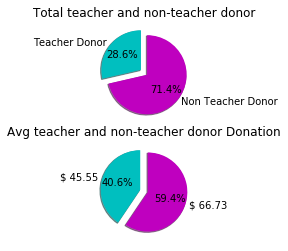

In [92]:
yes_no = [int(yes_don),int(no_don)]
names = ['Teacher Donor','Non Teacher Donor']
cols = ['c','m']

ynmean=['$ '+str(round(float(yes_avgdon),2)),'$ '+str(round(float(no_avgdon),2))]

ynmeang=[float(yes_avgdon), float(no_avgdon)]
plt.subplot(212)
plt.pie(ynmeang,labels=ynmean,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Avg teacher and non-teacher donor Donation")

plt.subplot(211)
plt.pie(yes_no,labels=names,colors=cols,startangle=90,shadow=True,explode=(0.1,0.1),autopct='%1.1f%%')
plt.title("Total teacher and non-teacher donor")


In [93]:
temp1=donor_donation.groupby('DonorState').agg({'DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).limit(10)

In [94]:
temp2=donor_donation.groupby('DonorCity').agg({'DonationAmount':'max'}).orderBy('max(DonationAmount)',ascending=False).where(donor_donation.DonorCity != 'null' ).limit(10)

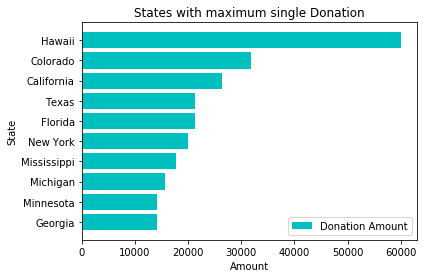

In [96]:
amount,state = dfToList(temp1,'max(DonationAmount)'),dfToList(temp1,'DonorState')

plt.barh(state[::-1],amount[::-1],label="Donation Amount",color='c')
plt.xlabel("Amount")
plt.ylabel("State")
plt.title("States with maximum single Donation")
plt.legend()

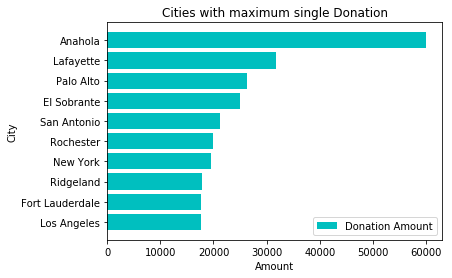

In [97]:
amount, state = dfToList(temp2,'max(DonationAmount)'), dfToList(temp2,'DonorCity')

plt.barh(state[::-1],amount[::-1],label="Donation Amount",color='c')
plt.xlabel("Amount")
plt.ylabel("City")
plt.title("Cities with maximum single Donation")
plt.legend()

In [99]:
tmp=TeachersDF.groupby(year(TeachersDF.TeacherFirstProjectPostedDate)).agg({'TeacherID':'count'}).orderBy('year(TeacherFirstProjectPostedDate)')

Text(0.5, 0, 'Year')

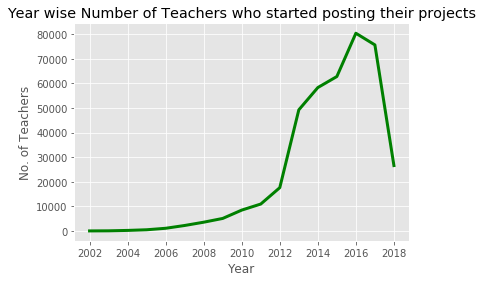

In [101]:
x, y=tmp.rdd.map(lambda x : x['year(TeacherFirstProjectPostedDate)']).collect(), tmp.rdd.map(lambda x : x['count(TeacherID)']).collect()
plt.plot(x,y,'g',linewidth=3)

plt.title("Year wise Number of Teachers who started posting their projects")
plt.ylabel("No. of Teachers")
plt.xlabel("Year")


In [123]:
#TeachersDF.select('TeacherPrefix').distinct().show()

In [152]:
teachers_df=TeachersDF.where(TeachersDF['TeacherPrefix'] != 'null').groupBy('TeacherPrefix').agg({'TeacherPrefix':'count'})

labels,values = teachers_df.rdd.map(lambda x : x['TeacherPrefix']).collect(), teachers_df.rdd.map(lambda x : x['count(TeacherPrefix)']).collect()

trace = go.Pie(labels=labels, values=values, marker=dict(colors=['#25e475', '#ee1c96',]))

layout = go.Layout(title='Number of Donations with Optional Donations', width=800, height=500)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Text(0.5, 1.0, 'School Metro Type')

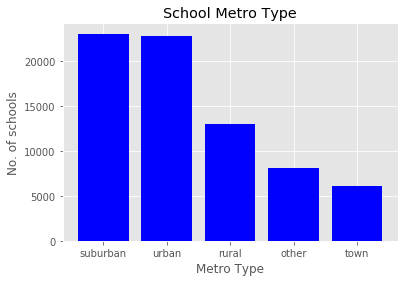

In [151]:
school_df=schoolsDF.groupBy('SchoolMetroType').agg({'SchoolMetroType':'count'}).orderBy('count(SchoolMetroType)',ascending=False)
no_scl, metronm = school_df.rdd.map(lambda row : row['count(SchoolMetroType)']).collect(), school_df.rdd.map(lambda row : row['SchoolMetroType']).collect()
metronm=[ 'other' if itm =='unknown' else itm for itm in metronm]
plt.ylabel("No. of schools")
plt.xlabel("Metro Type")
plt.bar(metronm,no_scl,color='b')
plt.title("School Metro Type")

Text(0.5, 1.0, 'Top States with maximum Schools')

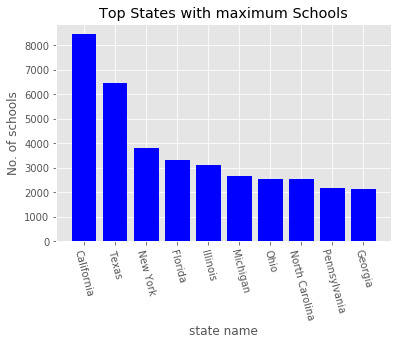

In [156]:
sclsts=schoolsDF.groupBy('SchoolState').agg({'SchoolState':'count'}).orderBy('count(SchoolState)',ascending=False).limit(10)

no_scl, state = dfToList(sclsts,'count(SchoolState)'), dfToList(sclsts,'SchoolState')

plt.ylabel("No. of schools")
plt.xlabel("state name")
plt.xticks(rotation=-75)
plt.bar(state,no_scl,color='b')
plt.title("Top States with maximum Schools")


Text(0.5, 1.0, 'Top Cities with maximum Schools')

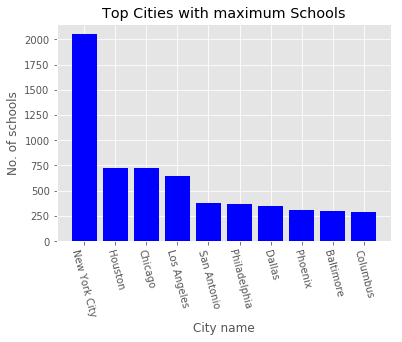

In [157]:
sclct=schoolsDF.groupBy('SchoolCity').agg({'SchoolCity':'count'}).orderBy('count(SchoolCity)',ascending=False).limit(10)

no_scl, state = dfToList(sclct,'count(SchoolCity)'), dfToList(sclct,'SchoolCity')
 
plt.ylabel("No. of schools")
plt.xlabel("City name")
plt.xticks(rotation=-75)
plt.bar(state,no_scl,color='b')
plt.title("Top Cities with maximum Schools")